In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow as tf
#from tensorflow import keras
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [2]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
filelist_trainx = sorted(glob.glob('trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

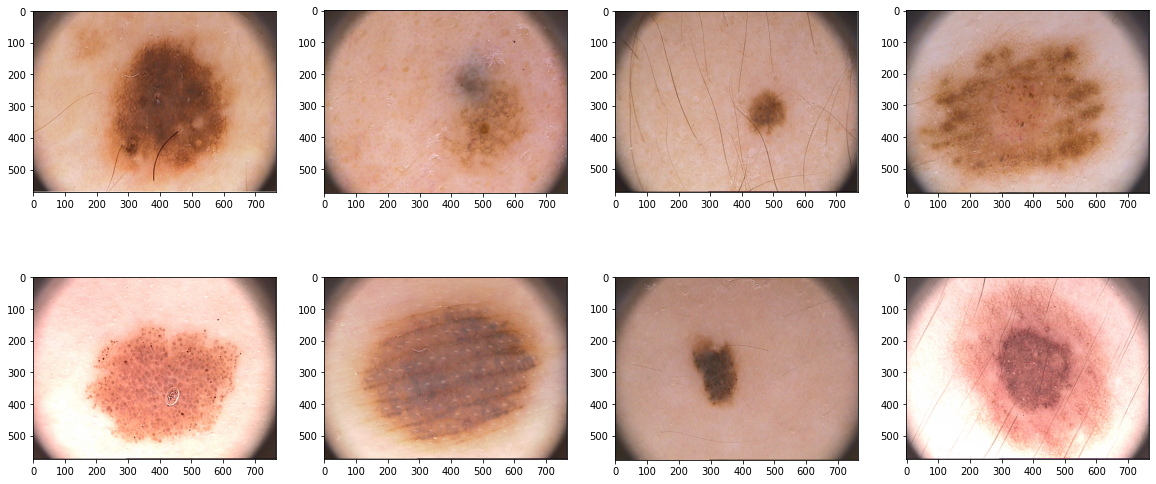

In [5]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

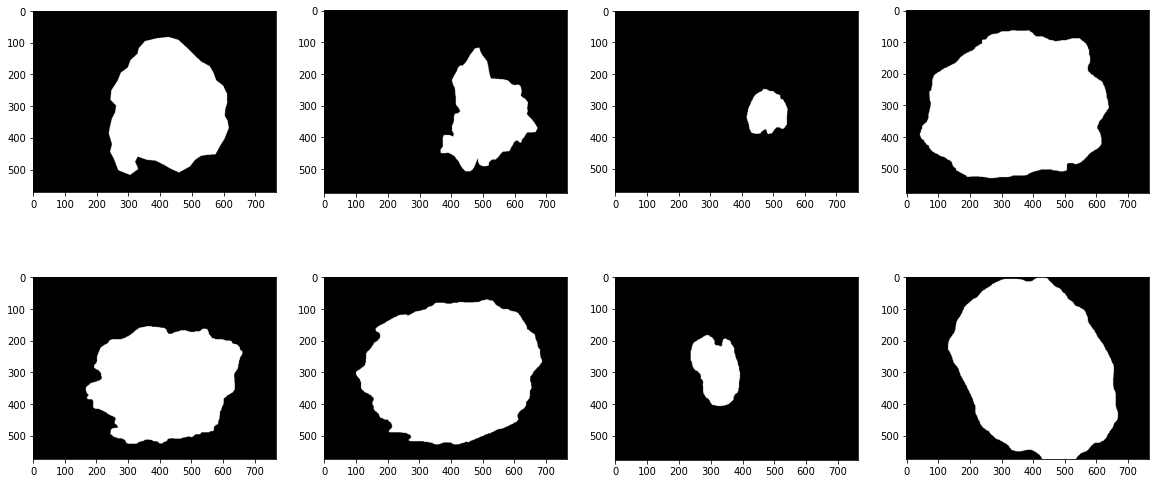

In [6]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

In [7]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [8]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [9]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [10]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coe(y_true, y_pred)

In [11]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [13]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [14]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [15]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [16]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(X_train, Y_train)

In [17]:
x_train_full = np.concatenate([X_train, x_rotated, x_flipped])
y_train_full = np.concatenate([Y_train, y_rotated, y_flipped])

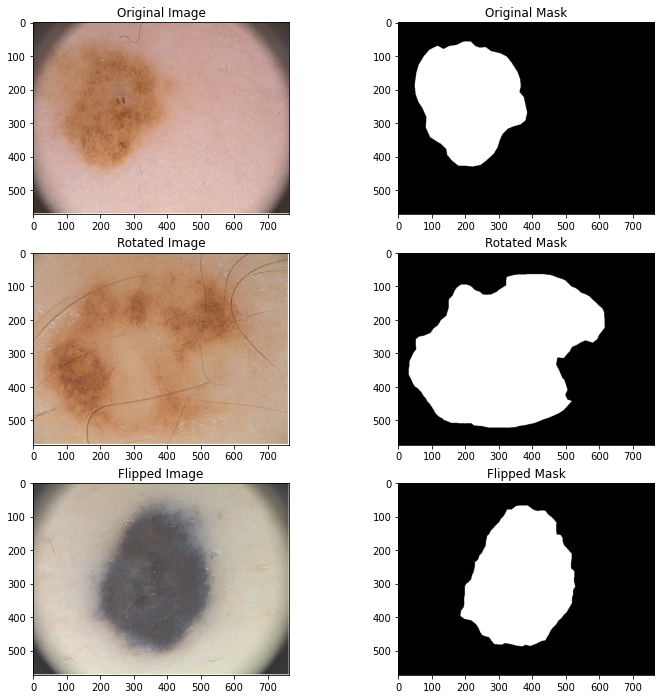

In [18]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train_full[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train_full[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_train_full[img_num+1])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_train_full[img_num+1], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_train_full[img_num+2])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_train_full[img_num+2], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [19]:
#x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)
kf = KFold(n_splits = 2, shuffle=False)

In [20]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [21]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    #out = concatenate([conv3x3,conv3x3,conv3x3], axis=3)

    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(input_size=(256,256,1)):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input(input_size)

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    #mresblock3 = MultiResBlock(32*4, pool2)
    #pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    #mresblock3 = ResPath(32*4, 2, mresblock3)

    #mresblock4 = MultiResBlock(32*8, pool3)
    #pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    #mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*4, pool2)

    #up6 = concatenate([Conv2DTranspose(
    #    32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock5], axis=3)
    #mresblock6 = MultiResBlock(32, up6)

    #up7 = concatenate([Conv2DTranspose(
    #    32*4, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock3], axis=3)
    #mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [22]:
losses = []
accuracies = []
ious = []
dice_cos = []
precisions = []
recalls = []
histories = []

y_train_full = y_train_full[:, :, :, np.newaxis]

for j, (train_idx, val_idx) in enumerate(kf.split(x_train_full, y_train_full)):
    
    print('\nFold ',j)
    X_train_cv = x_train_full[train_idx]
    y_train_cv = y_train_full[train_idx]
    X_valid_cv = x_train_full[val_idx]
    y_valid_cv= y_train_full[val_idx]
    
    model = MultiResUnet(input_size = (224, 224, INPUT_CHANNELS))

    model.compile(optimizer= Adam(lr = 1e-5), loss= dice_coef_loss,
                  metrics=[iou, dice_coe, precision, recall, accuracy])
    
    model_checkpoint = ModelCheckpoint(str(j+1) + '_skin_leison.hdf5', 
                                       monitor='loss', 
                                       verbose=1, 
                                       save_best_only=True)
    
    callbacks_list = [model_checkpoint]
    y_train_cv=tf.cast(y_train_cv, tf.float32)
    X_valid_cv=tf.cast(X_valid_cv, tf.float32)
    y_valid_cv=tf.cast(y_valid_cv, tf.float32)
    history = model.fit(X_train_cv,
                     y_train_cv,
                     epochs= 2,
                     callbacks = callbacks_list,
                     batch_size= 16,
                     validation_data=(X_valid_cv, y_valid_cv))
    
    model = load_model(str(j+1) + '_skin_leison.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss,
                                                                           'iou': iou, 'precision': precision, 'recall': recall,
                                                                           'accuracy': accuracy, 'dice_coe': dice_coe})

    results = model.evaluate(X_valid_cv, y_valid_cv)
    results = dict(zip(model.metrics_names,results))
                   
    accuracies.append(results['accuracy'])
    losses.append(results['loss'])
    ious.append(results['iou'])
    dice_cos.append(results['dice_coe'])
    precisions.append(results['precision'])
    recalls.append(results['recall'])
    histories.append(history)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])

In [ ]:
#model_0.load_weights('unet_1_epoch.h5')

print('average accuracy : ', np.mean(np.array(accuracies)), '+-', np.std(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)), '+-', np.std(np.array(losses)))
print('average iou : ', np.mean(np.array(ious)), '+-', np.std(np.array(ious)))
print('average dice_coe : ', np.mean(np.array(dice_cos)), '+-', np.std(np.array(dice_cos)))
print('average precision : ', np.mean(np.array(precisions)), '+-', np.std(np.array(precisions)))
print('average recall : ', np.mean(np.array(recalls)), '+-', np.std(np.array(recalls)))

In [ ]:
model = load_model('1_skin_leison.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss,
                                                           'iou': iou, 'precision': precision, 'recall': recall,
                                                           'accuracy': accuracy, 'dice_coe': dice_coe})

In [ ]:
for i in range(3):
    index=np.random.randint(1,300)
    pred=model.predict(x_train_full[index][np.newaxis, :, :, :])

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(x_train_full[index])
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(y_train_full[index]))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Predicted mask')
    plt.show()